# Bug 1795017: recent crash report volume (2023-08-16)

This notebook looks at overall crash report volume over the last 20 weeks that is
contributing to overload of processors and processing backlog.

In [1]:
import datetime
import json
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

I used [crashstats-tools](https://github.com/willkg/crashstats-tools) to download volume data by product for the last 20 weeks.

```shell
$ supersearchfacet --_facets=product --relative-range=20w --period=daily --format=csv > volume_data.csv
```

Then I graphed the facet data over time.

Text(0, 0.5, 'count')

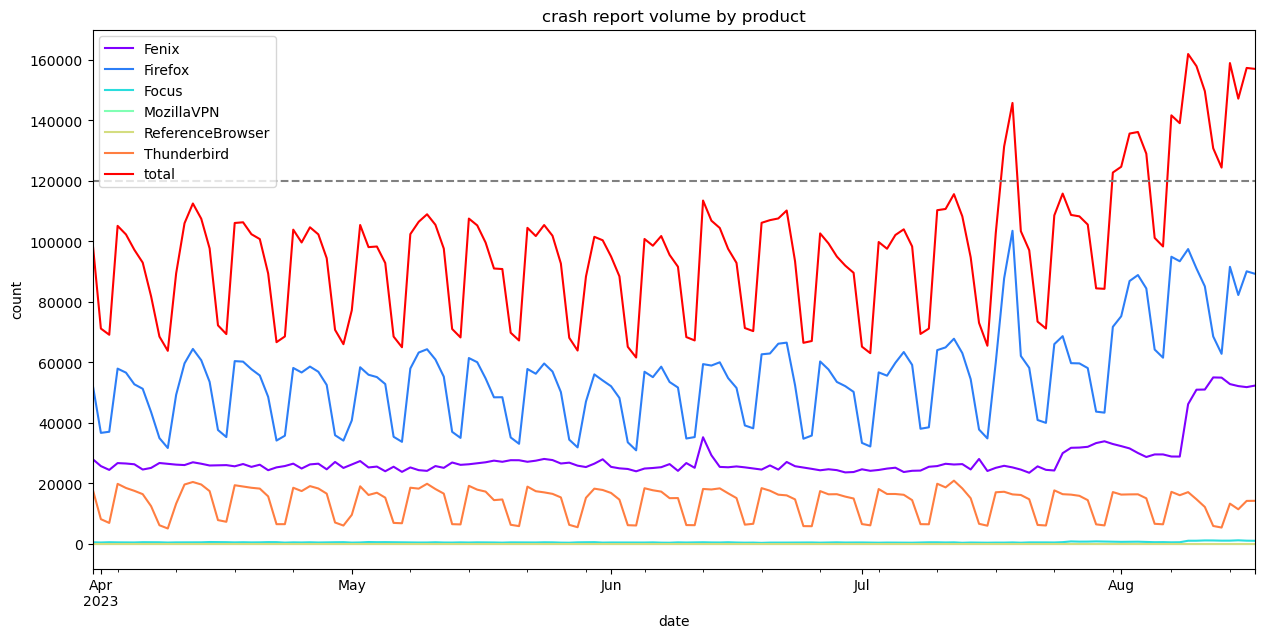

In [2]:
# Data file is a csv with [date, list of product totals, total, --]
#
# Note: Path is dependent on this notebook running in the Docker container.
data = pd.read_csv("./bug_1795017_data/volume_data.csv")
products = list(data.columns)
products.remove("date")
products.remove("--")

# print(products)

data["dates"] = pd.to_datetime(data["date"], format="%Y-%m-%d %H:%M:%S", utc=True)

# print(data["dates"].to_string())

input_data = data[["dates"]]
first_date = input_data["dates"].min()
last_date = input_data["dates"].max()
data.set_index("dates", inplace=True)

color = iter(plt.cm.rainbow(np.linspace(0, 1, len(products))))

for product in products:
    df = data[product]
    c = next(color)
    df.plot(c=c, xlabel=product, ylabel="count", figsize=(15, 7))

plt.legend()
plt.axhline(y=120000, linestyle="--", color="gray")
plt.title("crash report volume by product")
plt.xlabel("date")
plt.ylabel("count")

There's significant movement in Firefox. Let's break that down by channel. Note that we get a lot of junk 
channel values, so we restrict to known good channel values.

```shell
$ supersearchfacet --_facets=release_channel --relative-range=8w --product=Firefox --release_channel=esr --release_channel=release --release_channel=nightly --release_channel=beta --period=daily --format=csv > firefox_volume.csv
```

Text(0, 0.5, 'count')

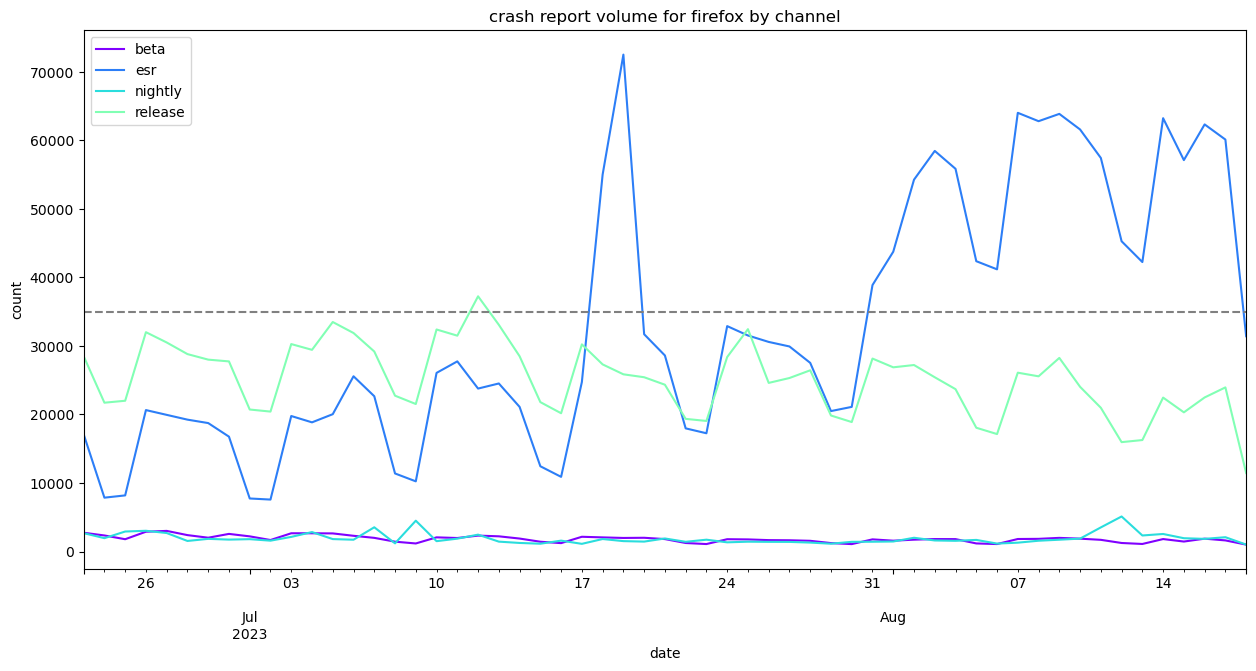

In [3]:
# Data file is a csv with [date, list of release channels, total, --]
#
# Note: Path is dependent on this notebook running in the Docker container.
data = pd.read_csv("./bug_1795017_data/firefox_volume.csv")
channels = list(data.columns)
channels.remove("date")
channels.remove("--")
channels.remove("total")

# print(channels)

data["dates"] = pd.to_datetime(data["date"], format="%Y-%m-%d %H:%M:%S", utc=True)

# print(data["dates"].to_string())

input_data = data[["dates"]]
first_date = input_data["dates"].min()
last_date = input_data["dates"].max()
data.set_index("dates", inplace=True)

color = iter(plt.cm.rainbow(np.linspace(0, 1, len(products))))

for channel in channels:
    df = data[channel]
    c = next(color)
    df.plot(c=c, xlabel=channel, ylabel="count", figsize=(15, 7))

plt.legend()
plt.axhline(y=35000, linestyle="--", color="gray")
plt.title("crash report volume for firefox by channel")
plt.xlabel("date")
plt.ylabel("count")

Ergo, the large jump is caused by moving users using older operating systems to ESR channel.

Let's look at the Firefox ESR channel broken down by platform.

```shell
$ supersearchfacet --_facets=platform --product=Firefox --release_channel=esr --relative-range=8w --period=daily --format=csv > firefox_esr_volume.csv
```

Text(0, 0.5, 'count')

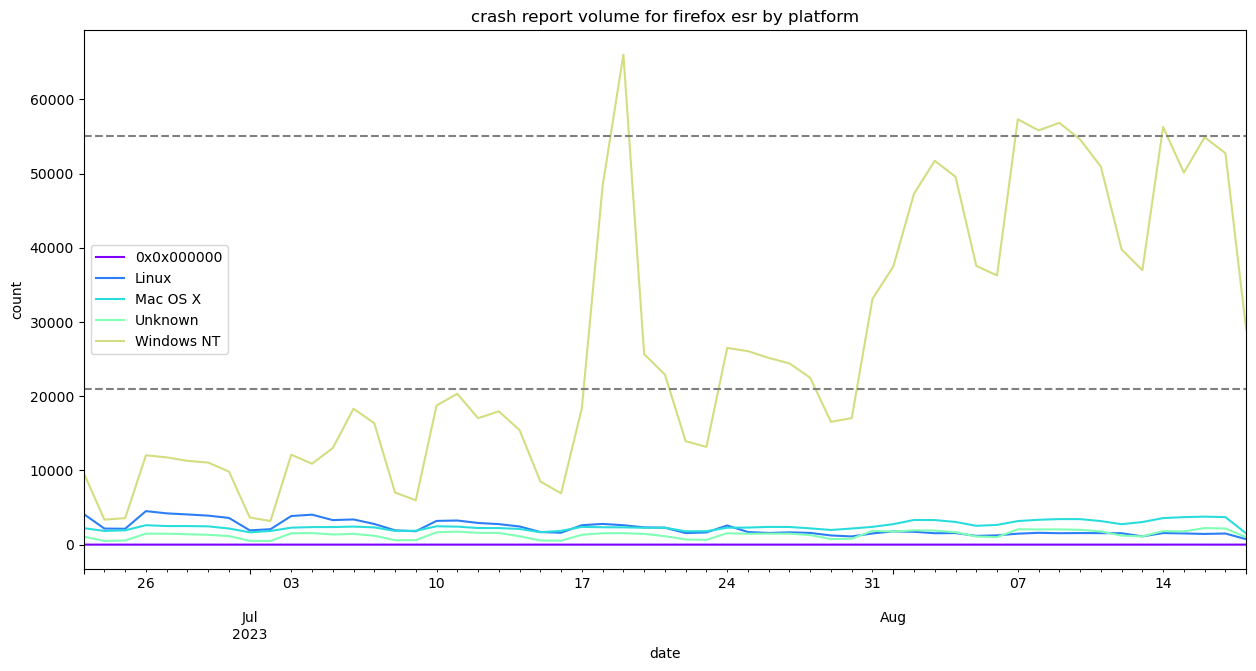

In [4]:
# Data file is a csv with [date, list of platforms, total, --]
#
# Note: Path is dependent on this notebook running in the Docker container.
data = pd.read_csv("./bug_1795017_data/firefox_esr_volume.csv")
platforms = list(data.columns)
platforms.remove("date")
platforms.remove("--")
platforms.remove("total")

# print(channels)

data["dates"] = pd.to_datetime(data["date"], format="%Y-%m-%d %H:%M:%S", utc=True)

# print(data["dates"].to_string())

input_data = data[["dates"]]
first_date = input_data["dates"].min()
last_date = input_data["dates"].max()
data.set_index("dates", inplace=True)

color = iter(plt.cm.rainbow(np.linspace(0, 1, len(products))))

for platform in platforms:
    df = data[platform]
    c = next(color)
    df.plot(c=c, xlabel=platform, ylabel="count", figsize=(15, 7))

plt.legend()
plt.axhline(y=21000, linestyle="--", color="gray")
plt.axhline(y=55000, linestyle="--", color="gray")
plt.title("crash report volume for firefox esr by platform")
plt.xlabel("date")
plt.ylabel("count")

# Conclusion

The large jump in crash report volume is caused by moving users using older Windows versions systems to ESR channel.
The crash ingestion collector throttles Firefox Windows release channel crash reports because we get so many of them.
We should consider throttling Firefox Windows ESR crash reports.